<a href="https://colab.research.google.com/github/a-parida12/Capsules/blob/master/FashionMNISTGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gzip
import h5py
import pickle
import PIL
import os
import numpy as np

try:
    from tqdm import trange
except ImportError:
    trange = range
    
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.cmap'] = 'gray'

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
train_set = torchvision.datasets.FashionMNIST('./sample_data/',train=True, transform=transforms.ToTensor(), download=True)

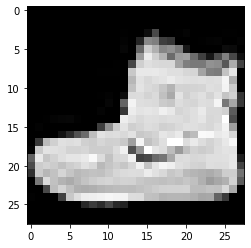

In [0]:
plt.imshow(train_set[0][0][0])

In [0]:
def img_to_point_cloud(input_image, voxel):

    non_zero_coord = np.transpose(np.nonzero(input_image))
    
    # dict for fast looking of neighboor ocupancy
    non_zero_dict = {}
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            non_zero_dict[str([i,j])] = any(np.all([i,j] == non_zero_coord, axis=1))

    cloud = []
    
    for n in range(len(non_zero_coord)):
        x = non_zero_coord[n][0]
        y = non_zero_coord[n][1]
            
        components = [0,1]
        
        # top
        if not non_zero_dict[str([x-1, y])]:
            components.append(2)
        
        # bottom
        if not non_zero_dict[str([x+1, y])]:
            components.append(3)
        
        # left
        if not non_zero_dict[str([x, y-1])]:
            components.append(4)
        
        # right
        if not non_zero_dict[str([x, y+1])]:
            components.append(5)
        
        pixel_cloud = np.concatenate(voxel[components])
                
        # move the voxel to its position
        pixel_cloud[:,0] +=x
        pixel_cloud[:,1] += y
        
        cloud.append(pixel_cloud)
    
    cloud = np.concatenate(cloud)
    
    # make max range 0-1
    xyzmin = np.min(cloud[:,:3], axis=0)
    xyzmax = np.max(cloud[:,:3], axis=0)
    diff = xyzmax - xyzmin
    cloud[:,:3] = ((cloud[:,:3] - xyzmin[np.argmax(diff)]) / diff[np.argmax(diff)])
    
    # 0 mean
    cloud[:,:3] -= np.mean(cloud[:,:3], axis=0)

    return cloud

In [0]:
MIN_X, MAX_X = (-0.5, 0.5)
MIN_Y, MAX_Y = (-0.5, 0.5)
MIN_Z, MAX_Z = (-3, 3)

N_X = 5
N_Y = 5
N_Z = 30

In [0]:
## VOXELS CREATION
# with normals

front = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X),
                             np.linspace(MIN_Y, MAX_Y, N_Y),
                             MAX_Z )).T.reshape(-1,3) 
front = np.concatenate((front, [[1,0,0]] * len(front)), axis=1)


back = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X), 
                            np.linspace(MIN_Y, MAX_Y, N_Y), 
                            MIN_Z )).T.reshape(-1,3)    
back = np.concatenate((back, [[-1,0,0]] * len(back)), axis=1)


top = np.array(np.meshgrid(MIN_X,
                           np.linspace(MIN_Y, MAX_Y, N_Y), 
                           np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3)
top = np.concatenate((top, [[0,0,1]] * len(top)), axis=1)


bottom = np.array(np.meshgrid(MAX_X, 
                              np.linspace(MIN_Y, MAX_Y, N_Y), 
                              np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3) 
bottom = np.concatenate((bottom, [[0,0,-1]] * len(bottom)), axis=1)


left = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X), 
                            MIN_Y,
                            np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3)
left = np.concatenate((left, [[0,-1,0]] * len(left)), axis=1)


right = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X), 
                             MAX_Y, 
                             np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3)   
right = np.concatenate((right, [[0,1,0]] * len(right)), axis=1)


voxel = np.array([front, back, top, bottom, left, right])